# Autoencoder Feature Importance (Permutation on Reconstruction Error)

This notebook loads the v6 autoencoder, computes reconstruction MSE, then estimates permutation feature importance by shuffling each input column and measuring the MSE delta.


In [36]:
import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

# Add project root to path to pick up tabster_paths
try:
    _THIS = Path(__file__).resolve()
except NameError:
    _THIS = Path.cwd()
for cand in [_THIS.parent, _THIS.parent.parent, *_THIS.parents]:
    if (cand / "tabster_paths.py").exists():
        sys.path.insert(0, str(cand))
        break
from tabster_paths import MERGED_DIR, MODELS_DIR  # noqa: E402

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NPZ_PATH = MERGED_DIR / "unified_data_v6.npz"
MODEL_PATH = MODELS_DIR / "autoencoder.pt"
LATENT_DIM = 64
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


In [37]:
def _split_blocks_v6(X, npz):
    """Slice X into v6 blocks using the lengths saved in the npz."""
    n_num = len(npz["numeric_features"])
    n_bin = len(npz["binary_features"])
    n_ds = len(npz["dataset_onehot_cols"])
    n_nat = len(npz["mask_native_cols"])
    n_str = len(npz["mask_struct_cols"])
    i = 0
    X_num = X[:, i:i + n_num]; i += n_num
    X_bin = X[:, i:i + n_bin]; i += n_bin
    X_ds1 = X[:, i:i + n_ds]; i += n_ds
    X_nat = X[:, i:i + n_nat]; i += n_nat
    X_str = X[:, i:i + n_str]; i += n_str
    assert i == X.shape[1], "Block slicing mismatch with v6 layout"
    return X_num, X_bin, X_ds1, X_nat, X_str


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=LATENT_DIM):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 512), nn.ReLU(),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


def reconstruction_mse(model, X, device, batch_size=4096):
    loss_fn = nn.MSELoss(reduction="mean")
    mean_loss = 0.0
    n = len(X)
    for i in range(0, n, batch_size):
        xb = torch.tensor(X[i:i + batch_size], dtype=torch.float32, device=device)
        out, _ = model(xb)
        mean_loss += loss_fn(out, xb).item() * len(xb)
    return mean_loss / n


npz = np.load(NPZ_PATH, allow_pickle=True)
X = npz["X"]
order = [str(x) for x in npz["order"]]
print("Datasets order:", order)

# Build AE input = numeric_z | binary | native_mask | struct_mask  (drop dataset one-hot)
X_num, X_bin, X_ds1, X_nat, X_str = _split_blocks_v6(X, npz)
X_ae = np.concatenate([X_num, X_bin, X_nat, X_str], axis=1).astype(np.float32)
input_dim = X_ae.shape[1]
print("AE input shape:", X_ae.shape)

# Feature names in the same order as X_ae columns
feat_names = (
    list(npz["numeric_features"]) +
    list(npz["binary_features"]) +
    list(npz["mask_native_cols"]) +
    (list(npz["mask_struct_cols"]) if len(npz["mask_struct_cols"]) else [])
)
assert len(feat_names) == X_ae.shape[1], "Feature name count mismatch"

# Load model
ae = AutoEncoder(input_dim=input_dim, latent_dim=LATENT_DIM).to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE)
ae.load_state_dict(state)
ae.eval()
print("Loaded", MODEL_PATH)


Datasets order: ['Covertype', 'Higgs', 'HELOC']
AE input shape: (242514, 324)
Loaded /Users/lisavanoosten/Desktop/Data Science/(2) Applied Machine Learning/UnifiedTabularLearning/models/autoencoder.pt


In [38]:
# Evaluate baseline reconstruction MSE on a subset to keep runtime reasonable
subset = 20000  # adjust as needed
if subset and subset < len(X_ae):
    idx = np.random.default_rng(SEED).choice(len(X_ae), size=subset, replace=False)
    X_eval = X_ae[idx]
else:
    X_eval = X_ae
baseline_mse = reconstruction_mse(ae, X_eval, DEVICE)
print(f"Baseline MSE on eval subset ({len(X_eval)} rows): {baseline_mse:.6f}")


Baseline MSE on eval subset (20000 rows): 0.000232


In [39]:
# Permutation feature importance: shuffle each column, recompute MSE, measure delta
def permutation_importance(model, X_eval, feature_names, device, batch_size=4096):
    base = reconstruction_mse(model, X_eval, device, batch_size=batch_size)
    deltas = []
    for j, name in enumerate(feature_names):
        Xp = X_eval.copy()
        rng = np.random.default_rng(SEED)
        rng.shuffle(Xp[:, j])
        mse = reconstruction_mse(model, Xp, device, batch_size=batch_size)
        deltas.append((name, mse - base, mse, base))
        if (j + 1) % 50 == 0:
            print(f"Processed {j + 1}/{len(feature_names)} features")
    return deltas

deltas = permutation_importance(ae, X_eval, feat_names, DEVICE, batch_size=2048)
df_imp = pd.DataFrame(deltas, columns=["feature", "delta_mse", "mse_permuted", "mse_base"])
df_imp = df_imp.sort_values("delta_mse", ascending=False).reset_index(drop=True)
display(df_imp.head(30))
df_imp.to_csv("results/feature_importance_autoencoder_v6.csv", index=False)
print("Saved importance → results/feature_importance_autoencoder_v6.csv")


Processed 50/324 features
Processed 100/324 features
Processed 150/324 features
Processed 200/324 features
Processed 250/324 features
Processed 300/324 features


,feature,delta_mse,mse_permuted,mse_base
0,PRI_jet_num,0.004952,0.005184,0.000232
1,DER_sum_pt,0.003829,0.004061,0.000232
2,PRI_jet_all_pt,0.003680,0.003912,0.000232
3,DER_pt_ratio_lep_tau,0.002134,0.002366,0.000232
4,DER_pt_h,0.001831,0.002063,0.000232
5,PRI_tau_pt,0.001729,0.001961,0.000232
6,PRI_lep_pt,0.001669,0.001901,0.000232
7,DER_mass_jet_jet_native_mask,0.001571,0.001803,0.000232
8,DER_prodeta_jet_jet_native_mask,0.001567,0.001800,0.000232
9,PRI_jet_subleading_phi_native_mask,0.001567,0.001799,0.000232


Saved importance → results/feature_importance_autoencoder_v6.csv


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("results/feature_importance_autoencoder_v6.csv")  # adjust path if needed


In [43]:
def assign_group(feature):
    if feature.endswith("_struct_mask"):
        return "Struct mask"
    if feature.endswith("_native_mask"):
        return "Native mask"
    if feature.startswith(("PRI_", "DER_")):
        return "Higgs physics"
    if feature.startswith(("Soil_Type", "Wilderness_Area")):
        return "Covertype categorical"
    if feature.startswith((
        "Elevation", "Slope", "Hillshade",
        "Horizontal_Distance", "Aspect"
    )):
        return "Covertype terrain"
    if feature.startswith((
        "ExternalRiskEstimate", "Num", "Percent",
        "MSince", "NetFraction"
    )):
        return "HELOC credit"
    return "Other"

df["group"] = df["feature"].apply(assign_group)


In [44]:
group_importance = (
    df.groupby("group")
      .agg(
          mean_delta_mse=("delta_mse", "mean"),
          sum_delta_mse=("delta_mse", "sum"),
          n_features=("delta_mse", "count")
      )
      .sort_values("sum_delta_mse", ascending=False)
)

group_importance


,mean_delta_mse,sum_delta_mse,n_features
group,,,
Struct mask,0.000997,0.107646,108
Higgs physics,0.001293,0.038783,30
Native mask,0.000142,0.015381,108
Covertype terrain,0.000915,0.008231,9
HELOC credit,0.000163,0.003268,20
Other,0.000456,0.002279,5
Covertype categorical,0.000051,0.002263,44


/var/folders/y7/km8bnwwx4v1cyv0th5__yb1h0000gn/T/ipykernel_37309/3322971035.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


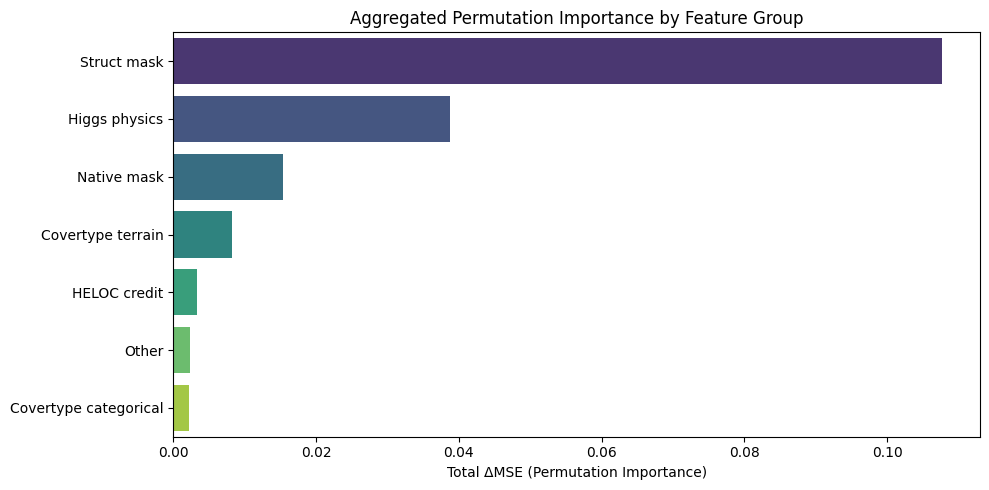

In [45]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=group_importance.reset_index(),
    x="sum_delta_mse",
    y="group",
    palette="viridis"
)
plt.title("Aggregated Permutation Importance by Feature Group")
plt.xlabel("Total ΔMSE (Permutation Importance)")
plt.ylabel("")
plt.tight_layout()
plt.show()


/var/folders/y7/km8bnwwx4v1cyv0th5__yb1h0000gn/T/ipykernel_37309/3128166083.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


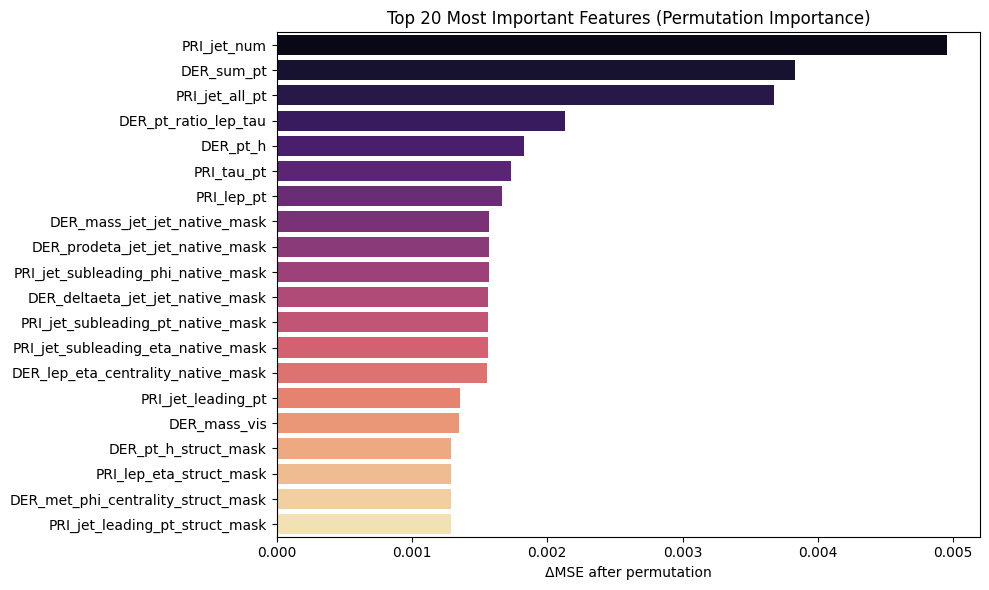

In [46]:
TOP_K = 20

top_feats = df.sort_values("delta_mse", ascending=False).head(TOP_K)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_feats,
    x="delta_mse",
    y="feature",
    palette="magma"
)
plt.title(f"Top {TOP_K} Most Important Features (Permutation Importance)")
plt.xlabel("ΔMSE after permutation")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [47]:
def dataset_of_feature(feature):
    # Higgs features
    if feature.startswith(("PRI_", "DER_")):
        return "Higgs"

    # Covertype features
    if feature.startswith((
        "Elevation", "Slope", "Hillshade", "Horizontal_Distance",
        "Aspect", "Soil_Type", "Wilderness_Area"
    )):
        return "Covertype"

    # HELOC features
    if feature.startswith((
        "ExternalRiskEstimate", "Num", "Percent",
        "MSince", "NetFraction"
    )):
        return "HELOC"

    return "Other"


In [48]:
df["dataset"] = df["feature"].apply(dataset_of_feature)


In [49]:
df_semantic = df[
    ~df["feature"].str.endswith("_struct_mask") &
    ~df["feature"].str.endswith("_native_mask")
]


In [50]:
top_higgs = (
    df_semantic[df_semantic["dataset"] == "Higgs"]
    .sort_values("delta_mse", ascending=False)
    .head(15)
)

top_higgs[["feature", "delta_mse"]]


,feature,delta_mse
0,PRI_jet_num,0.004952
1,DER_sum_pt,0.003829
2,PRI_jet_all_pt,0.003680
3,DER_pt_ratio_lep_tau,0.002134
4,DER_pt_h,0.001831
5,PRI_tau_pt,0.001729
6,PRI_lep_pt,0.001669
14,PRI_jet_leading_pt,0.001352
15,DER_mass_vis,0.001345
49,DER_deltar_tau_lep,0.001180


In [51]:
top_covertype = (
    df_semantic[df_semantic["dataset"] == "Covertype"]
    .sort_values("delta_mse", ascending=False)
    .head(15)
)

top_covertype[["feature", "delta_mse"]]


,feature,delta_mse
106,Elevation,0.001087
108,Hillshade_3pm,0.001076
109,Hillshade_9am,0.001039
113,Hillshade_Noon,0.000972
117,Slope,0.000921
121,Aspect_cos,0.000838
124,Horizontal_Distance_To_Roadways,0.000782
125,Horizontal_Distance_To_Fire_Points,0.000781
126,Horizontal_Distance_To_Hydrology,0.000735
130,Wilderness_Area1,0.000527


In [52]:
top_heloc = (
    df_semantic[df_semantic["dataset"] == "HELOC"]
    .sort_values("delta_mse", ascending=False)
    .head(15)
)

top_heloc[["feature", "delta_mse"]]


,feature,delta_mse
162,NumTrades60Ever2DerogPubRec,0.000196
163,NumSatisfactoryTrades,0.000194
165,PercentTradesNeverDelq,0.000187
166,PercentInstallTrades,0.000184
167,MSinceOldestTradeOpen,0.000182
168,ExternalRiskEstimate,0.000182
170,NumTotalTrades,0.000179
171,NumRevolvingTradesWBalance,0.000178
172,NetFractionRevolvingBurden,0.000176
173,NumTrades90Ever2DerogPubRec,0.000174


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_features(df_sub, title):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_sub,
        x="delta_mse",
        y="feature",
        palette="viridis"
    )
    plt.title(title)
    plt.xlabel("ΔMSE after permutation")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


/var/folders/y7/km8bnwwx4v1cyv0th5__yb1h0000gn/T/ipykernel_37309/415960828.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


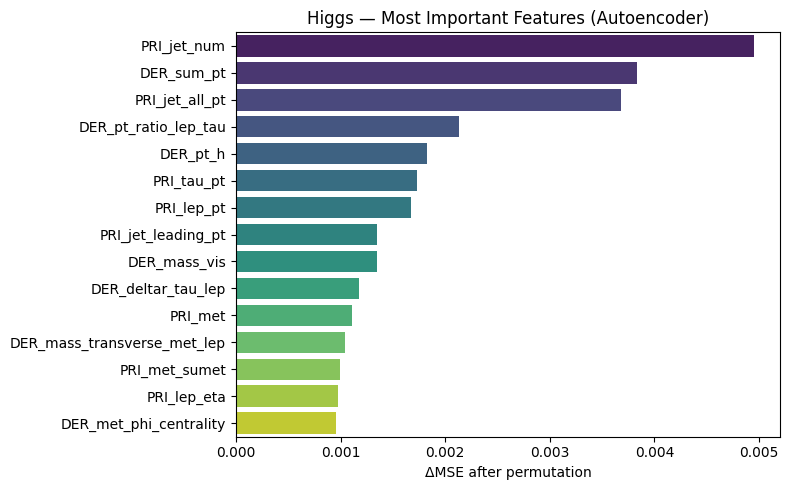

/var/folders/y7/km8bnwwx4v1cyv0th5__yb1h0000gn/T/ipykernel_37309/415960828.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


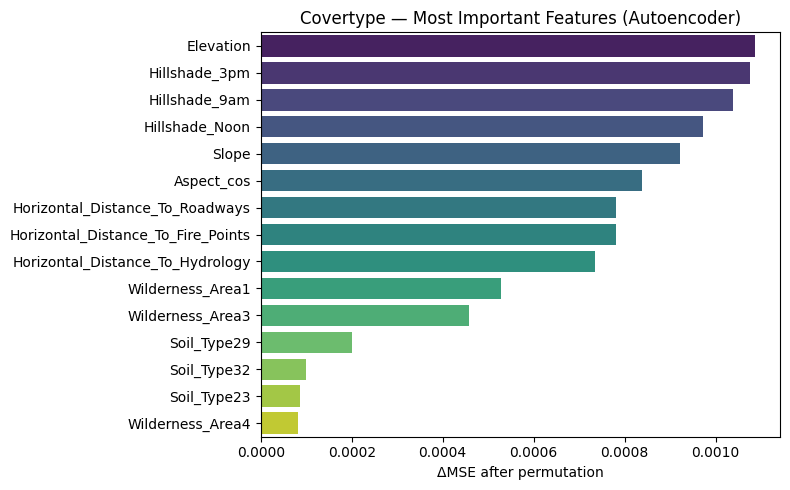

/var/folders/y7/km8bnwwx4v1cyv0th5__yb1h0000gn/T/ipykernel_37309/415960828.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


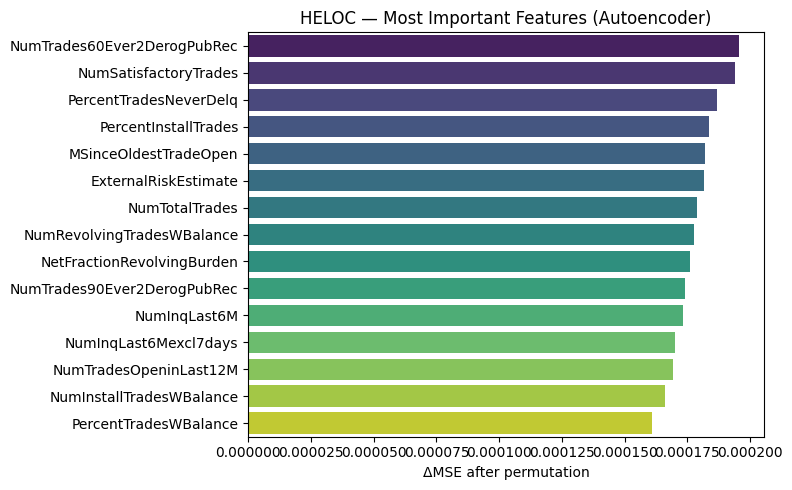

In [54]:
plot_top_features(top_higgs, "Higgs — Most Important Features (Autoencoder)")
plot_top_features(top_covertype, "Covertype — Most Important Features (Autoencoder)")
plot_top_features(top_heloc, "HELOC — Most Important Features (Autoencoder)")


Which original input features does the encoder rely on most to build a good latent representation